In [1]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../../WobbleSim')
import simulacra.dataset
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const
import numpy as np
import math
import scipy.optimize

import jabble.dataset
import jabble.loss
import jabble.model

import matplotlib.pyplot as plt

from jax.config import config; config.update("jax_enable_x64", True)

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:172: SyntaxWarning: Jitted function has static_argnums=(3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:172: SyntaxWarning: Jitted function has static_argnums=(3, 4, 5), but only accepts 5 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


In [2]:
import scipy.constants

<h1>44 - simple data varying splines n lines</h1>


In [3]:
import os
import datetime
today = datetime.date.today()
out_dir = os.path.join('..','out',today.strftime("%d-%m-%y"))
os.makedirs(out_dir,exist_ok=True)

In [4]:
def gaussian(x,mu,sigma):
    return np.exp(-(x - mu)**2/(2 * sigma**2)) #/ (2 * sigma * np.sqrt(2 * np.pi))

In [5]:
class GaussianModel(jabble.model.Model):
    def __init__(self,means,heights,resolution):
        super(GaussianModel, self).__init__()
        self.p = means
        self.heights = heights
        self.dx = jabble.dataset.delta_x(resolution)

    def call(self,p,x,i,*args):
        flux = np.ones(x.shape,dtype='float64') 
        
        for i,mean in enumerate(p):
            flux -= self.heights[i] * gaussian(x,mean,self.dx)
    
        return np.log(flux)
        

def create_dataset(true_model,snr,resolution):
    
    flux = np.zeros((epoches,*x_grid.shape),dtype=np.float64)
    for i in range(epoches):
        flux[i,:] = np.exp(true_model([],x_grid,i))

    # add noise
    for j in range(flux.shape[0]):
        for k in range(flux.shape[1]):
            flux[j,k] -= np.random.normal(0.0,np.abs(flux[j,k]/snr))

    ferr = flux/snr
    yerr = ferr/flux
    mask = np.zeros(flux.shape)
    dataset = jabble.dataset.Dataset(x_grid[None,:].repeat(epoches,0),np.log(flux),yerr,mask)
    return dataset

In [6]:
resolution = 120_000
snr        = 50
epoches    = 20

dx = jabble.dataset.delta_x(2*resolution)
lmin = 4560
lmax = 4600
n = 20
n2 = 5
x_grid    = np.arange(np.log(lmin),np.log(lmax),step=dx,dtype='float64')

wave_grid = np.exp(x_grid) * u.Angstrom

guess_vel  = np.linspace(-60,60,epoches) * u.km/u.s
extra_vel  = np.linspace(-30,30,epoches) * u.m/u.s
velocities = guess_vel + extra_vel
shifts     = jabble.dataset.shifts(velocities).value

line_padding = np.exp(np.max(shifts))
means_set = np.log(np.random.uniform(lmin + line_padding,lmax - line_padding,n))
heigt_set = np.random.uniform(0.3,0.7,n)

star_model = jabble.model.CompositeModel([jabble.model.ShiftingModel(shifts),GaussianModel(means_set,heigt_set,resolution)])

tell_model = GaussianModel(means_set,heigt_set,resolution)

true_model = star_model + tell_model

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
datasets = [create_dataset(true_model,snr,resolution),create_dataset(true_model,snr/2,resolution)]

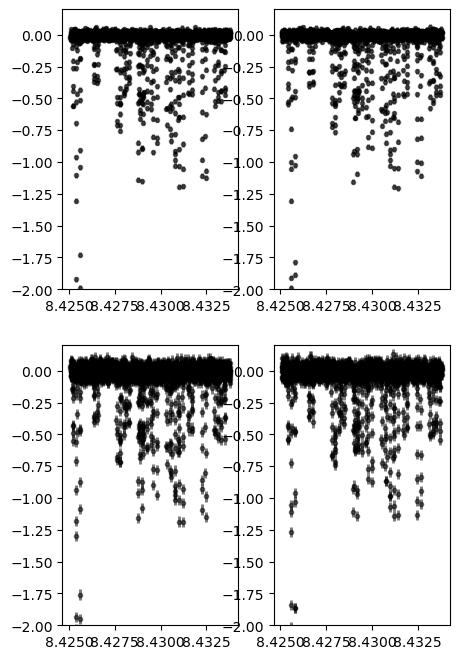

In [8]:
plt_inds = epoches
xpmin = np.log(4550)
xpmax = np.log(4560)
fig, axes = plt.subplots(len(datasets),2,figsize=(5,8))
for i,dataset in enumerate(datasets):
    axes[i,0].errorbar(datasets[i].xs[0,:],datasets[i].ys[0,:],datasets[i].yerr[0,:],fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)
    axes[i,1].errorbar(datasets[i].xs[-1,:],datasets[i].ys[-1,:],datasets[i].yerr[-1,:],fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)

#     axes[ele].set_xlim(xpmin-shifts[ele],xpmax-shifts[ele])
    axes[i,0].set_ylim(-2,0.2)
    axes[i,1].set_ylim(-2,0.2)
plt.show() 

In [9]:
loss        = jabble.loss.ChiSquare()
init_vels   = guess_vel
init_shifts = jabble.dataset.shifts(init_vels)

In [10]:
init_shifts.dtype

dtype('float64')

In [11]:
import jax

In [12]:
from collections import namedtuple

In [14]:
dataset.xs.shape

(20, 2097)

In [15]:
class MyShiftingModel(jabble.model.ShiftingModel):
    def grid_search(self,grid,loss,model,data,epoches=None):
        if epoches is None:
            epoches = slice(0,self.n)
        # put all submodels in fixed mode except the shiftingmodel
        # to be searched then take loss of each epoch
        # that we hand the loss a slice of the shift array
        # since at __call__ itll on take the shift_grid[i,j] element
        model.fix()
        # index is the index of the submodel to grid search this is redundant
        self.fit(epoches=epoches)
        if isinstance(model,jabble.model.ContainerModel):
            model.get_parameters()
        # this is called because this resets the parameters per model
        # array
        # I want to have this be done when a submodel is put into fix or fix mode
        loss_arr = np.empty(grid.shape)
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                loss_arr[i,j] = np.sum(out)
        return loss_arr

In [30]:
def get_model(p_val,model_grid,init_shifts):
    return jabble.model.IrwinHallModel_sparse(model_grid,p_val)+jabble.model.CompositeModel([MyShiftingModel(init_shifts),jabble.model.IrwinHallModel_sparse(model_grid,p_val)])

In [31]:
vel_padding = 100 * u.km/u.s
p_val = 2
model_grid = jabble.model.create_x_grid(x_grid,vel_padding,2*resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))
filenames = ['testdata_snr{}_20.stats'.format(snr),'testdata_snr{}_20.stats'.format(snr/2),'testdata_snr{}_5.stats'.format(snr),'testdata_snr{}_5.stats'.format(snr/2)]
model_set = [get_model(p_val,model_grid,init_shifts) for x in datasets]# for j in range(len(datasets))]

In [32]:
def train_cycle(model,dataset,loss):
    n_cycles = 1

    options1 = {'pgtol': 0.0}
    options2 = {'pgtol': 0.0}
    for iii in range(n_cycles):
        # Fitting Round 1
        print('fitting round {} 1'.format(iii))
        model.fix()
        model.fit(1)
        res1 = model.new_lbfgsb(loss,dataset,options=options1)
        print(res1['warnflag'],res1['nit'])
        if res1['warnflag'] == 2:
            print(res1['task'])
        
        # Fitting Round 2
        print('fitting round {} 2'.format(iii))
        model.fix()
        model.fit(0)
        res1 = model.new_lbfgsb(loss,dataset,options=options2)
        print(res1['warnflag'],res1['nit'])
        if res1['warnflag'] == 2:
            print(res1['task'])
            
        # Fitting Round 3
        print('fitting round {} 3'.format(iii))
        model.fix()
        model.fit(0)
        model.fit(1)
        res1 = model.new_lbfgsb(loss,dataset,options=options2)
        print(res1['warnflag'],res1['nit'])
        if res1['warnflag'] == 2:
            print(res1['task'])
        
    return model

In [33]:
model_set

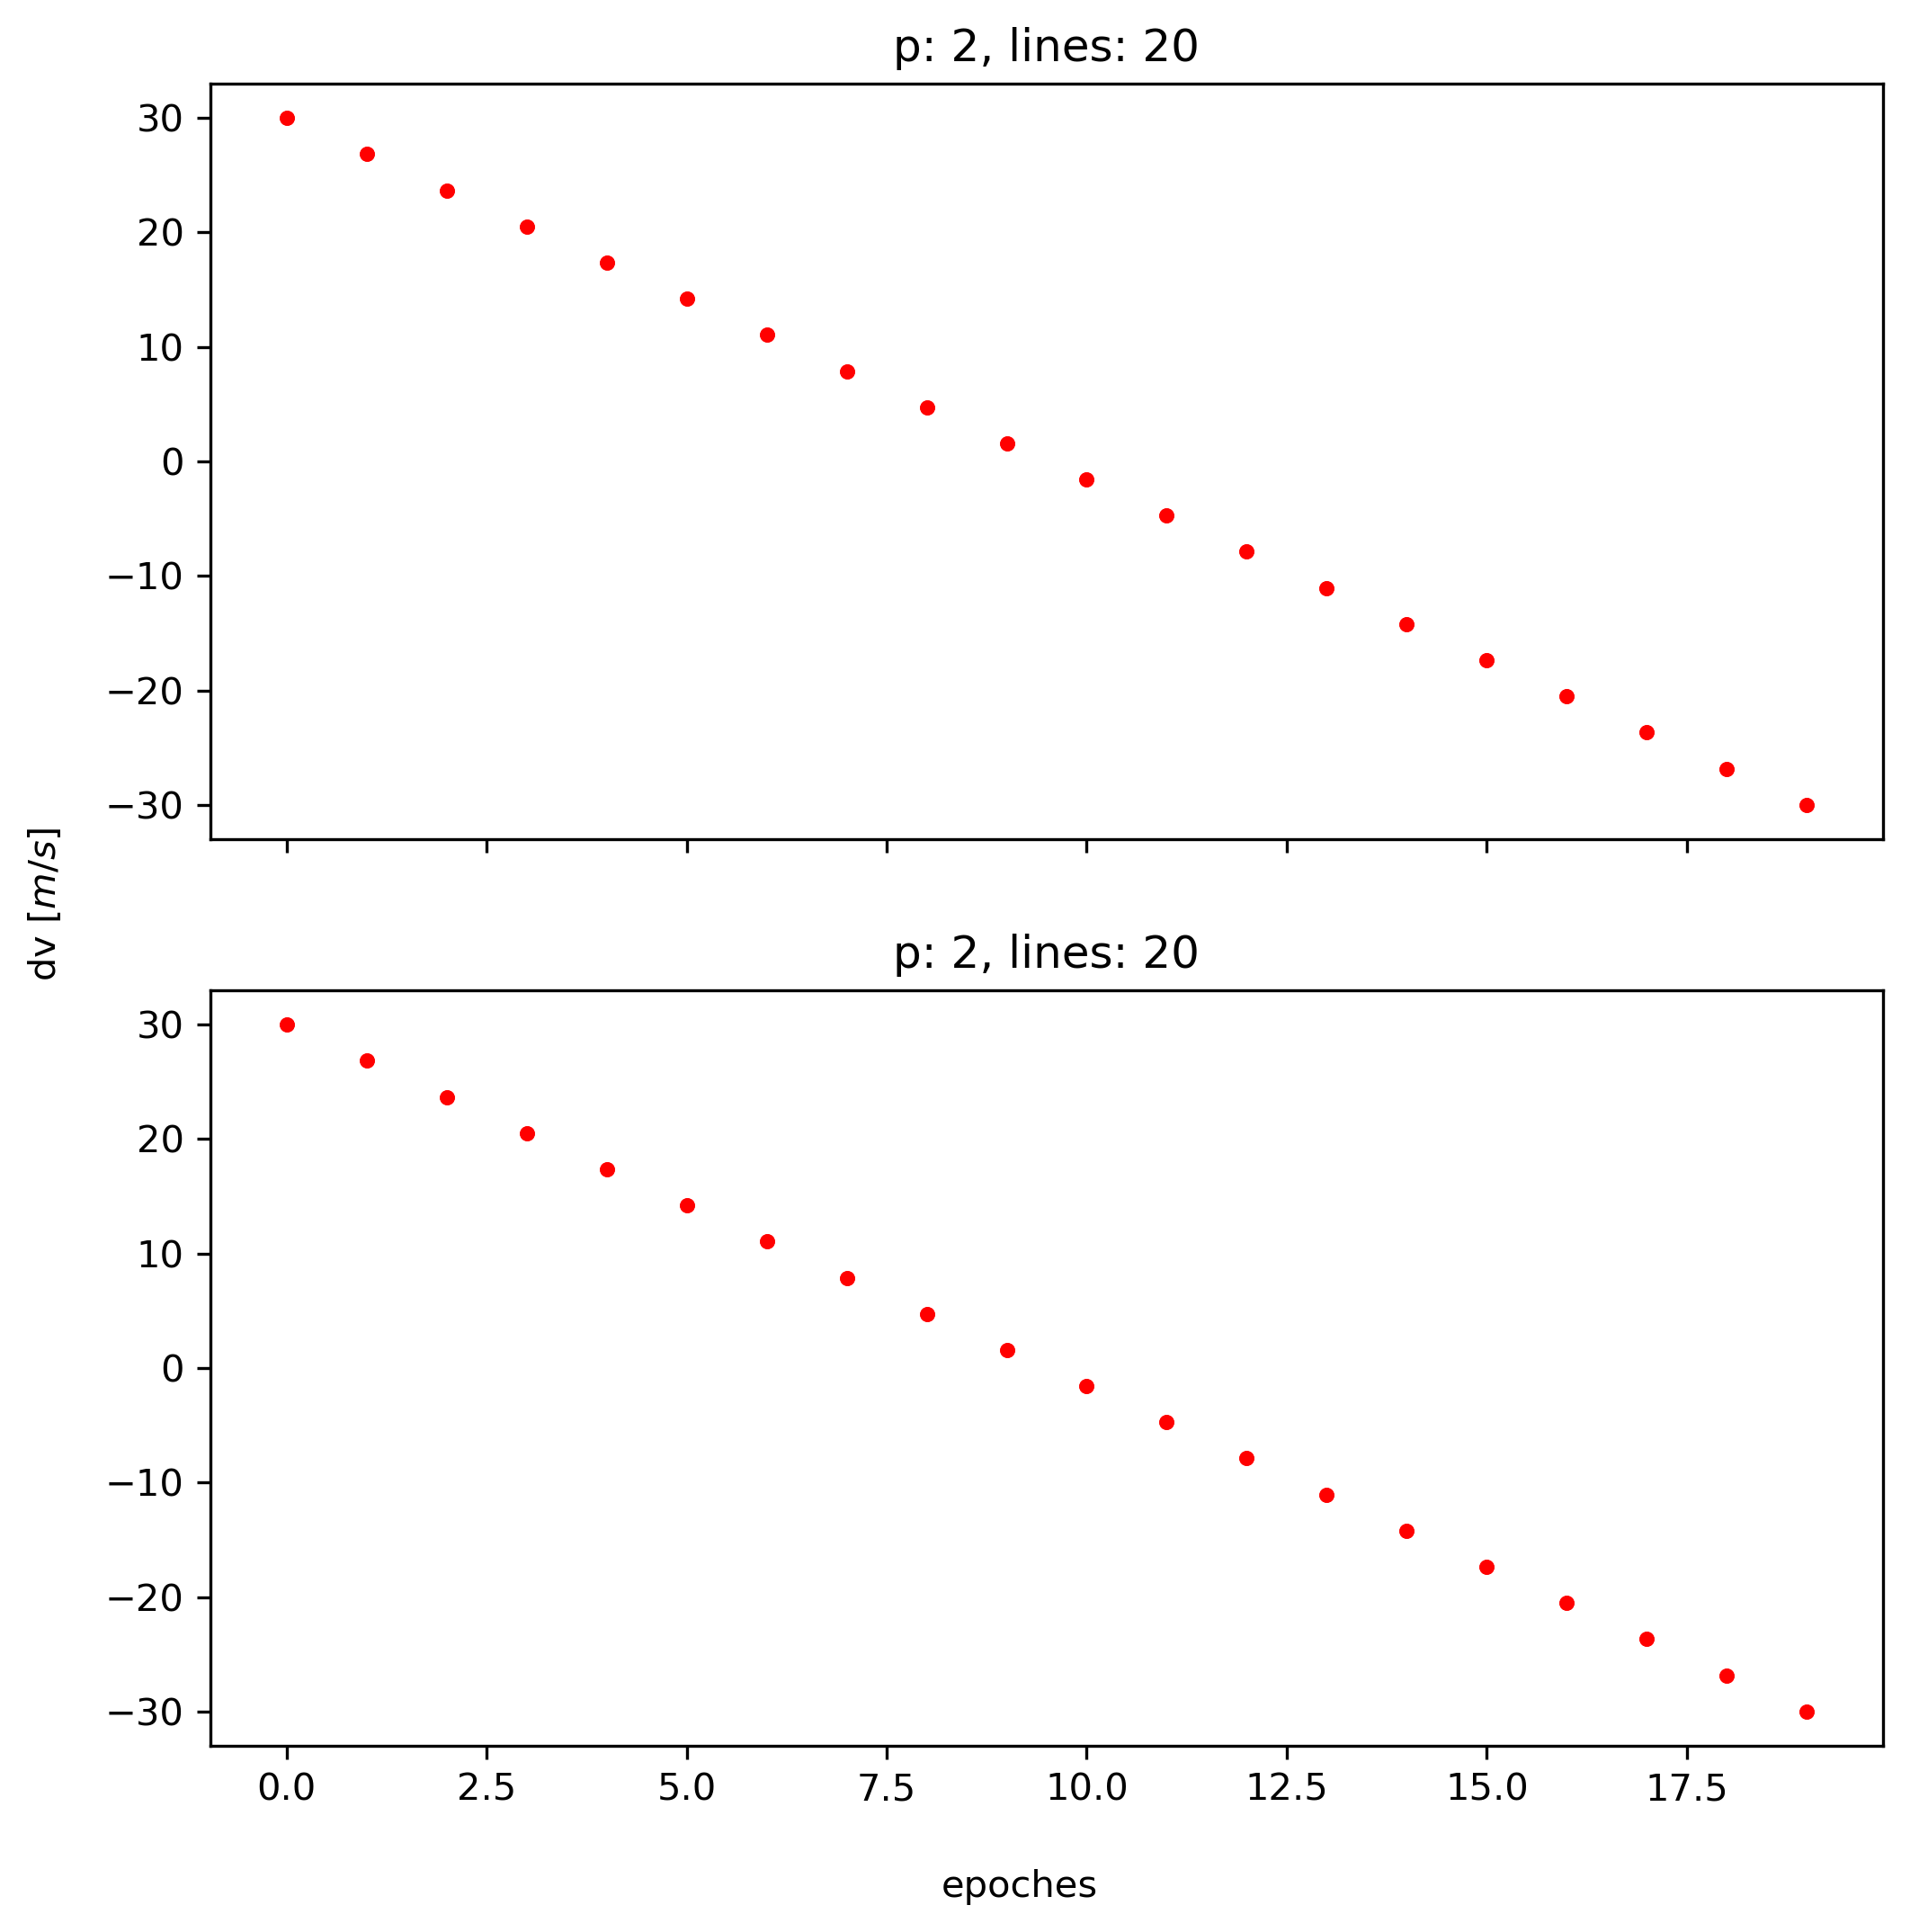

In [36]:
fig,ax = plt.subplots(len(model_set),figsize=(8,8),facecolor=(1,1,1),dpi=300,sharex=True,sharey=True)

epoch_range = np.arange(0,epoches,dtype=int)
# ax.plot(epoch_range,extra_vel.to(u.m/u.s).value,'.g',label='initialization')

for i in range(len(model_set)):
    for j in range(len(datasets)):
        estimate_vel = jabble.dataset.velocities(model_set[i][1][0].p)
        dv = estimate_vel.to(u.m/u.s).value - estimate_vel.to(u.m/u.s).value.mean() - velocities.to(u.m/u.s).value
        ax[i].plot(epoch_range,dv,'.r',label='estimation')
        ax[i].set_title('p: {}, lines: {}'.format(model_set[i][0].p_val,len(means_set)))
        # ax.set_ylim(-5.5e3,5.5e3)
        # for epoch in epoch_range:
        #     constant = 1e-5
        #     ax.arrow(epoch,dv[epoch],0.0,constant*stellar_model.results[-1].jac[epoch])

        # twin_ax = ax.twinx()
        # twin_ax.plot(stellar_model.results[-1]['jac'][:stellar_model[0].p.shape[0]],'om',alpha=0.3,label='gradient')
        # twin_ax.set_ylim(-1e9,1e9)
# plt.ylabel('dv [m/s]')
# plt.xlabel('epoches')
# plt.legend()
fig.text(0.04, 0.5, 'dv [$m/s$]', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'epoches', ha='center')
plt.savefig(os.path.join(out_dir,'44-dv.png'))
plt.show()

In [20]:
import cProfile, pstats, io
from pstats import SortKey

In [37]:
for j in range(len(model_set)):

    print('pval: ',model_set[i][0].p_val,'ds: ',i)
    cProfile.run('model_set[j]=train_cycle(model_set[j],datasets[j],loss)',os.path.join(out_dir,filenames[j]))        

pval:  2 ds:  1
fitting round 0 1
0 27
fitting round 0 2
0 11
fitting round 0 3
0 11
pval:  2 ds:  1
fitting round 0 1
0 23
fitting round 0 2
0 11
fitting round 0 3
0 12


In [22]:
# plt.plot(fischer_information,'.r')

In [23]:
import jabble.physics

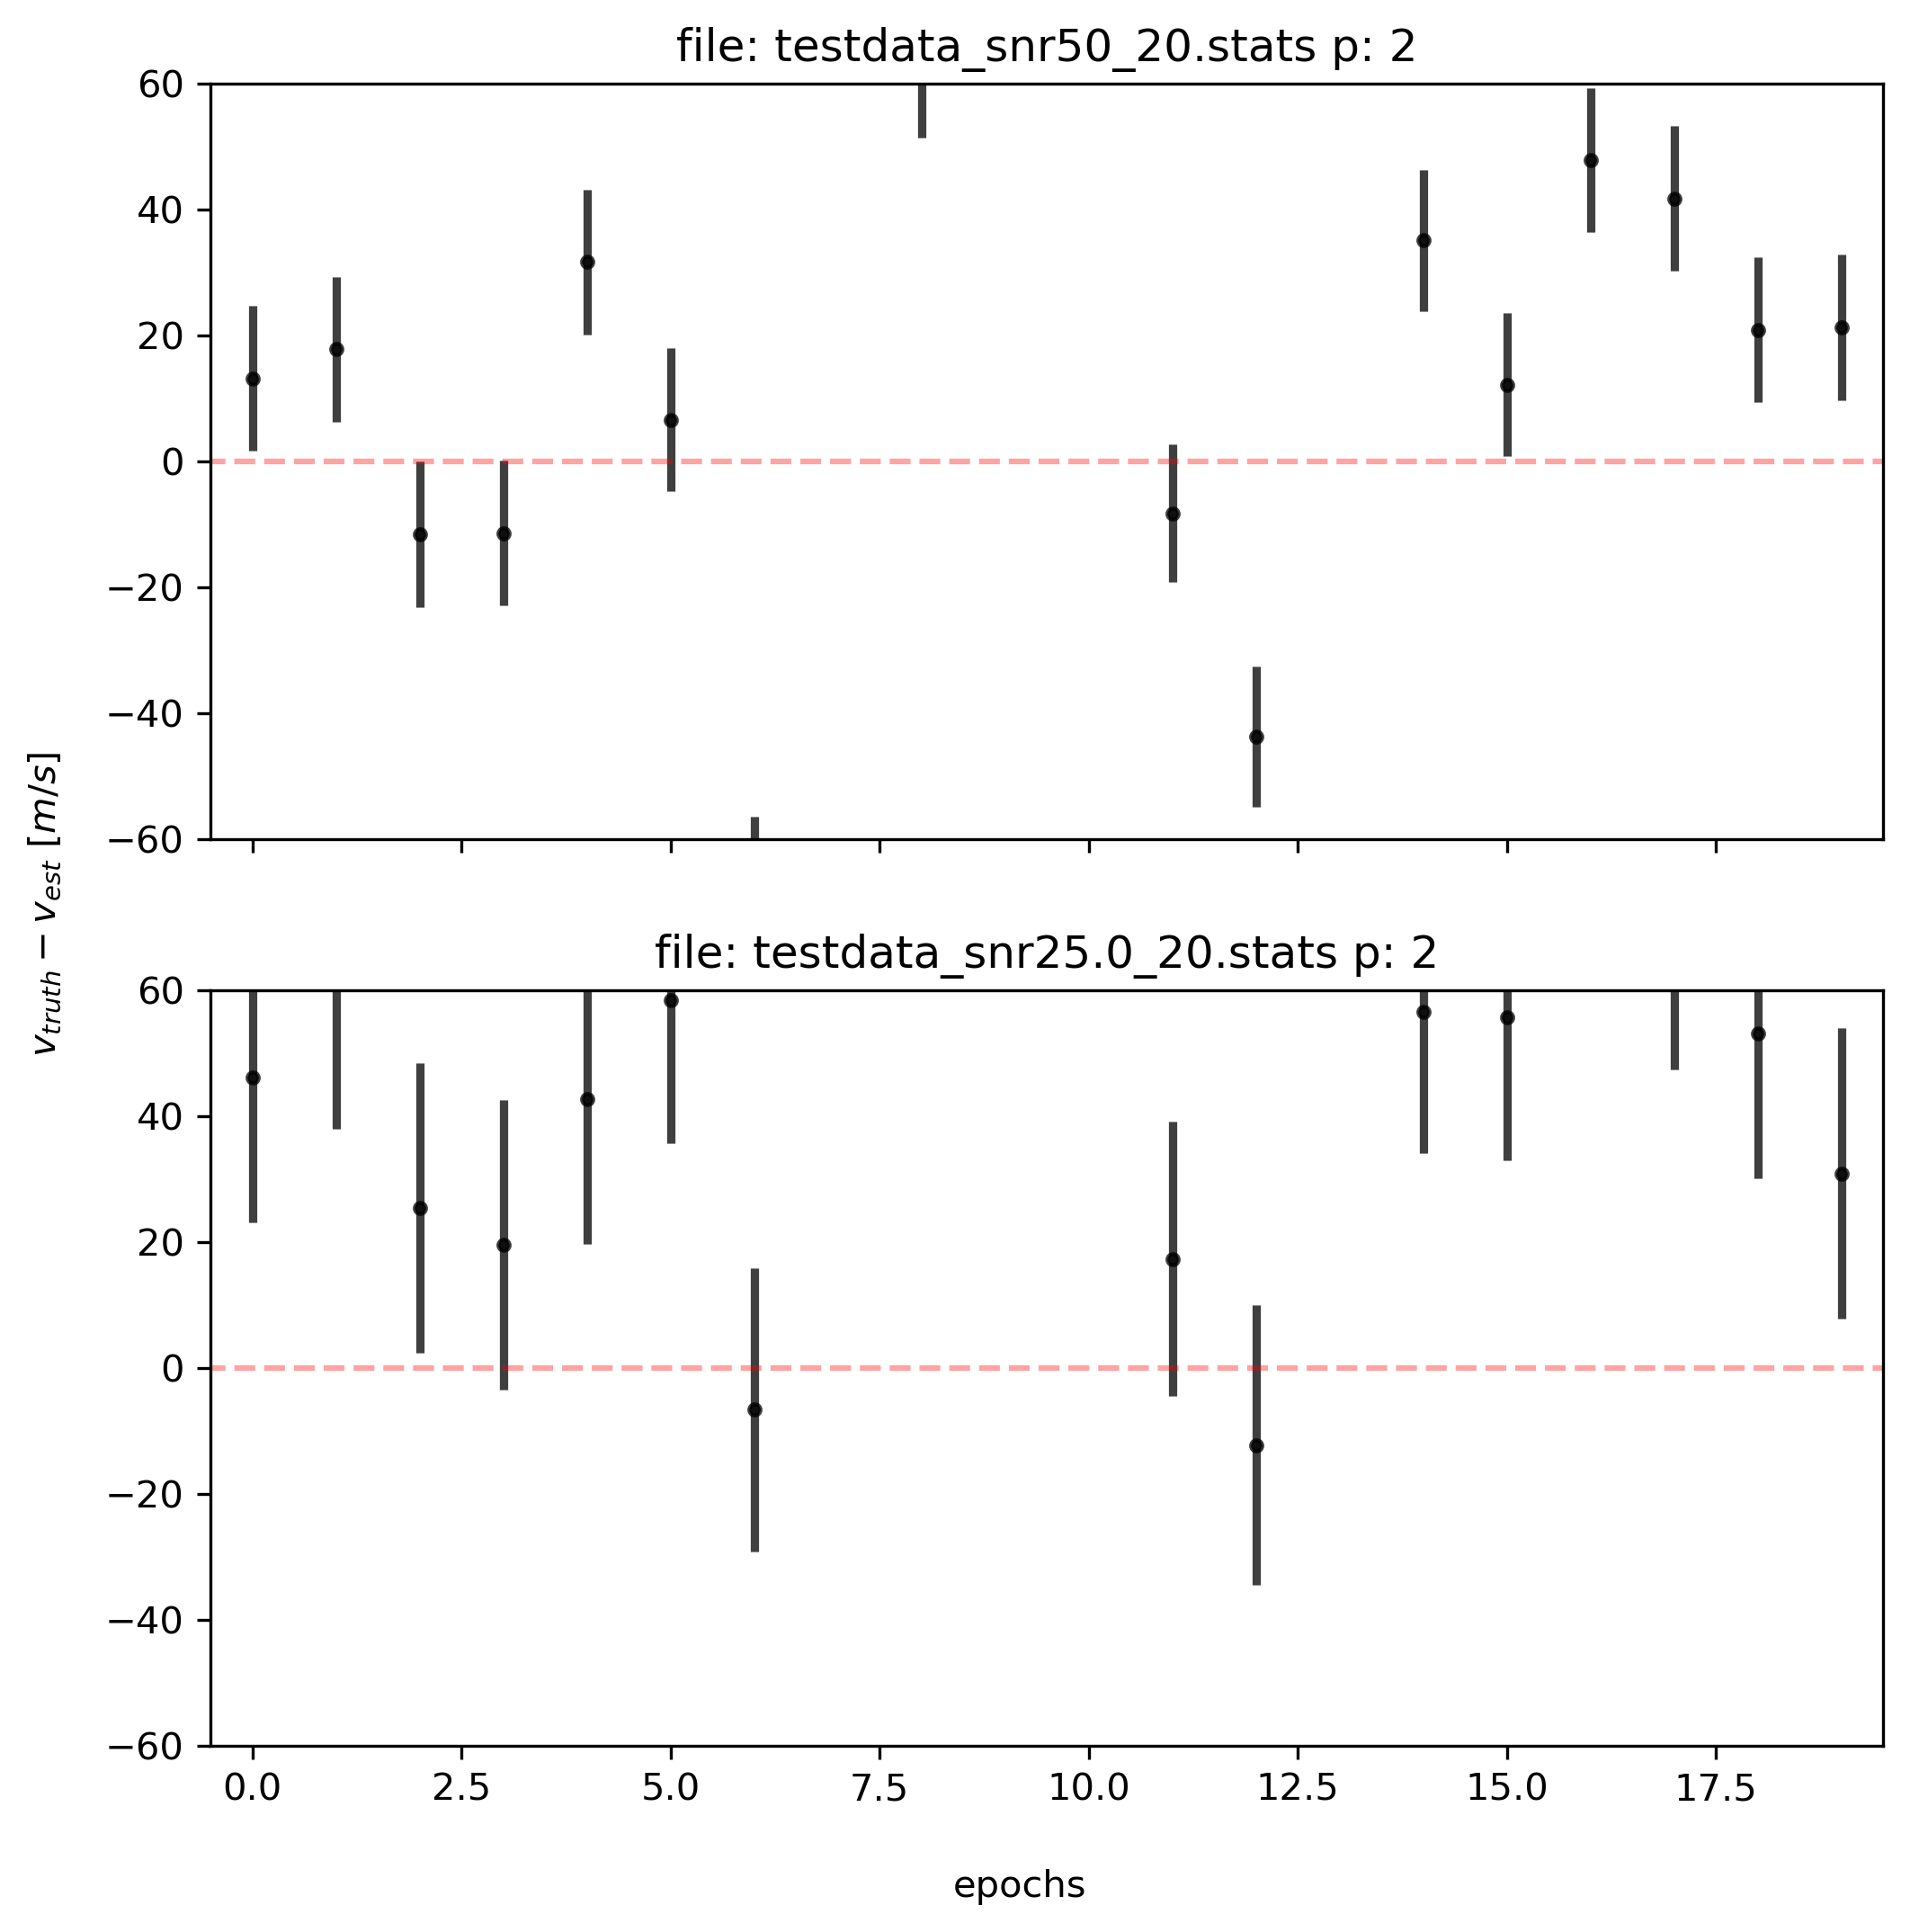

In [43]:
fig,ax = plt.subplots(len(model_set),figsize=(8,8),facecolor=(1,1,1),dpi=300,sharex=True,sharey=True)

epoch_range = np.arange(0,epoches,dtype=int)
# ax.plot(epoch_range,extra_vel.to(u.m/u.s).value,'.g',label='initialization')

for i in range(len(model_set)):
    fischer_information = np.zeros(epoches)
    for e_num in range(epoches):
        model_set[i].fix()
        model_set[i].fit(1,0)
        temp = jax.jacfwd(model_set[i], argnums=0)(model_set[i].get_parameters(),datasets[i].xs[e_num,:],e_num)
        # print(temp.shape)
        fischer_information[e_num] =  jnp.dot(temp[:,e_num]**2,datasets[i].yivar[e_num,:])
    
    for j in range(len(datasets)):
        dvddx = jnp.array([jax.grad(jabble.physics.velocities)(x) for x in model_set[i][1][0].p])
        verr = np.sqrt(1/fischer_information) * dvddx
        ax[i].hlines(y = 0.0, xmin = -2, xmax = epoches+2,linestyles='dashed',alpha=0.2,color='red')
        estimate_vel = jabble.dataset.velocities(model_set[i][1][0].p)
        tv = velocities.to(u.m/u.s).value   - velocities.to(u.m/u.s).value.mean()
        ev = estimate_vel.to(u.m/u.s).value - estimate_vel.to(u.m/u.s).value.mean()        
        # ax[i].plot(epoch_range,tv,'.r',alpha=0.5)        
        ax[i].errorbar(epoch_range,tv - ev,yerr=verr,fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)
        ax[i].set_title('file: {} p: {}'.format(filenames[i],model_set[i][0].p_val,len(means_set)))
        # ax.set_ylim(-5.5e3,5.5e3)
        # for epoch in epoch_range:
        #     constant = 1e-5
        #     ax.arrow(epoch,dv[epoch],0.0,constant*stellar_model.results[-1].jac[epoch])

        # twin_ax = ax.twinx()
        # twin_ax.plot(stellar_model.results[-1]['jac'][:stellar_model[0].p.shape[0]],'om',alpha=0.3,label='gradient')
        # twin_ax.set_ylim(-1e9,1e9)
# plt.ylabel('dv [m/s]')
# plt.xlabel('epoches')
# plt.legend()
plt.ylim(-60,60)
plt.xlim(-0.5,epoches-0.5)
fig.text(0.04, 0.5, '$v_{truth} - v_{est}$ [$m/s$]', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'epochs', ha='center')
plt.savefig(os.path.join(out_dir,'44-dv.png'))
plt.show()

In [25]:
from mpl_axes_aligner import align

In [26]:
def make_plot(model_num):
    x_window = np.log(4550) - np.log(4549)

    lrange = np.arange(lmin,lmax,1)
    plt_unit = u.Angstrom
    r_plots = 4
    
    vel_epoch = 5
    fig, axes = plt.subplots(epoches // r_plots, r_plots,figsize=(8,8),sharex=False,sharey=True,facecolor=(1, 1, 1),dpi=200)
    fig.suptitle(filenames[model_num])
    for plt_epoch in range(epoches):
        model_set[model_num].fix()
        model_set[model_num].fit(0)
        rv_model_deriv = jax.jacfwd(model_set[model_num], argnums=0)(model_set[model_num].get_parameters(),datasets[model_num].xs[plt_epoch,:],plt_epoch)
        # rv_loss_deriv = jax.jacfwd(loss, argnums=0)(model_set[model_num].get_parameters(),datasets[0],vel_epoch,model_set[model_num])
        
        model_set[model_num].fix()
    
        axes[plt_epoch // r_plots, plt_epoch % r_plots].errorbar(datasets[model_num].xs[plt_epoch,:],datasets[model_num].ys[plt_epoch,:],\
                                 datasets[0].yerr[plt_epoch,:],fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)

        true_model.fix()
        xplot = np.linspace(np.log(lmin),np.log(lmax),datasets[0].xs.shape[1]*10)
        axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(xplot,model_set[model_num]([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=1,alpha=0.5,ms=6)
        # axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(xplot,true_model([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=1,alpha=0.5,ms=6)
    
        
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_ylim(-2,1)
    #         axes[i,j].set_yticks([])
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticks(np.log(lrange))
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xlim(np.mean(means_set[4])-x_window+model_set[model_num][0].p[plt_epoch],np.mean(means_set[4])+x_window+model_set[model_num][0].p[plt_epoch])
    
        res_ax = axes[plt_epoch // r_plots, plt_epoch % r_plots].twinx()
        residual = loss(model_set[model_num].get_parameters(),datasets[0],plt_epoch,model_set[model_num])
        res_ax.step(datasets[0].xs[plt_epoch,:],residual,where='mid',alpha=0.3,label='residual')
        res_ax.set_ylim(0.0,20)
        res_ax.set_yticks([])
        # res_ax.step(model_set[i][j][1].xs+model_set[i][j][0].p[plt_epoch],\
        #             model_set[i][j].results[-2]['grad'][:],\
        #             where='mid',alpha=0.4,label='residual',zorder=-1)
        # res_ax.set_yticks([])
        
        # res_ax.step(x_grid,\
        #             rv_model_deriv[:,plt_epoch],\
        #             where='mid',alpha=0.4,label='RV Derivative',zorder=-1)
        
    #     res_ax.step(x_grid,\
    #                 rv_loss_deriv[:,plt_epoch],\
    #                 where='mid',alpha=0.4,label='RV Derivative',zorder=-1)
        
    #     align_yaxis(, 0, , 0)
        
        align.yaxes(axes[plt_epoch // r_plots, plt_epoch % r_plots], 0.0, res_ax, 0.0, 2./3.)

    # res.get_shared_y_axes().join(ax1, ax3)
    fig.text(0.5, 0.04, '$\lambda$', ha='center')
    fig.text(0.04, 0.5, 'y', va='center', rotation='vertical')
    # fig.text(0.96, 0.5, '$d \L /d \delta x$', va='center', rotation=270)
    # fig.text(0.96, 0.5, '$d f_{{{ji}}} /d \delta x_k$', va='center', rotation=270)
    fig.text(0.96, 0.5, 'residuals', va='center', rotation=270)
    
    plt.savefig(os.path.join(out_dir,'44-res_{}.png'.format(filenames[model_num])),dpi=300,bbox_inches='tight')
    plt.show()

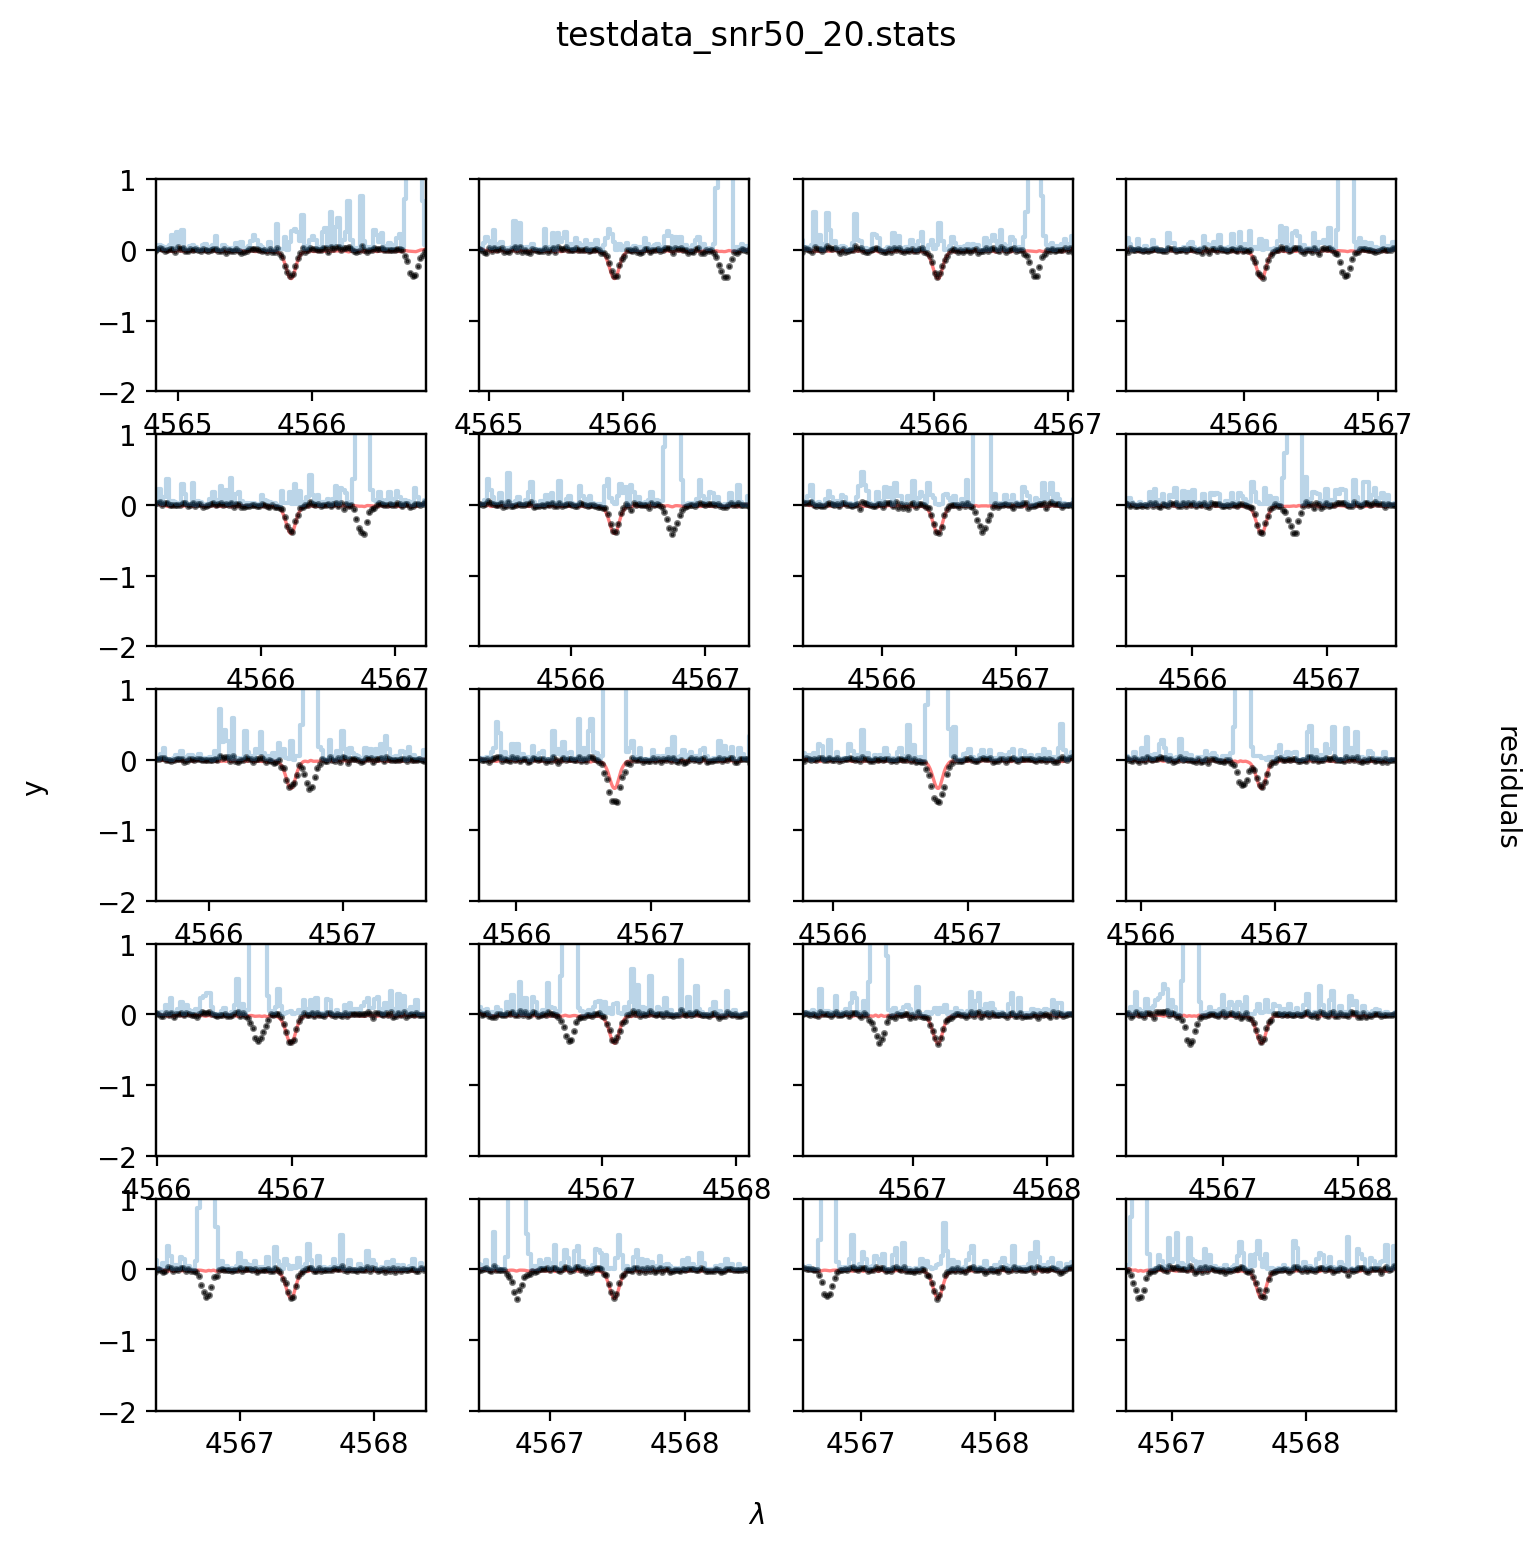

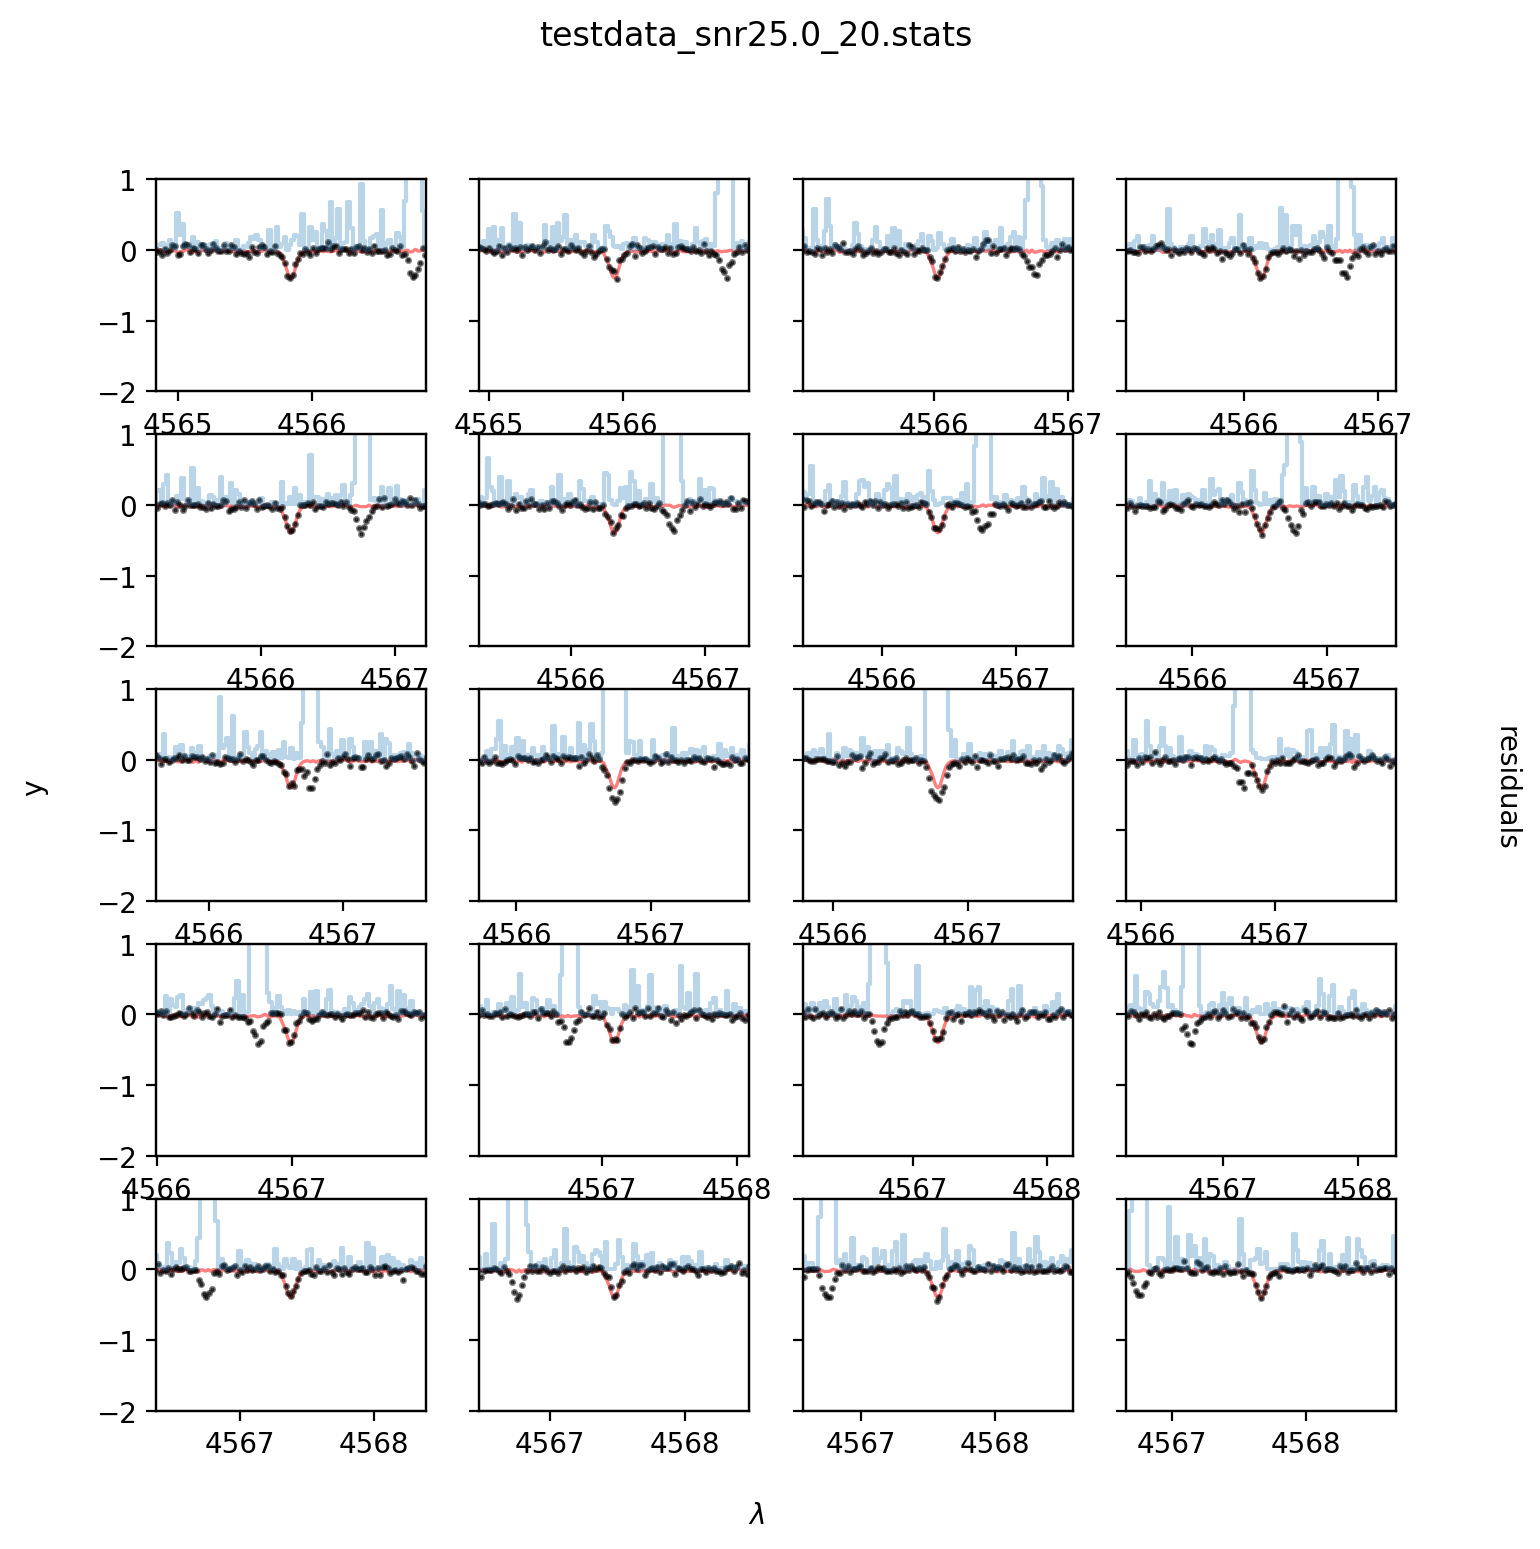

In [27]:
for model_num in range(len(model_set)):
    make_plot(model_num)